In [1]:
#librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    RocCurveDisplay
)
import joblib
import shap


Load the processed train and test sets for model training:

In [2]:
base_path = '/Users/ceciliatorres/Desktop/Personal work/maintenance_risk/maintenance_risk/notebooks/processed_data/'

X_train = joblib.load(base_path + 'X_train.pkl')
X_test = joblib.load(base_path + 'X_test.pkl')
y_train = joblib.load(base_path + 'y_train.pkl')
y_test = joblib.load(base_path + 'y_test.pkl')

print("X_train shape:", X_train.shape)
print("y_train value counts:")
print(y_train.value_counts())


X_train shape: (754, 9)
y_train value counts:
fail
0    440
1    314
Name: count, dtype: int64


Now let's begin with a baseline Logistic Regression model with class balancing to handle target imbalance.

In [3]:
model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

Now we can evaluate model performance using accuracy, recall, precision, and F1-score to understand prediction quality.

In [4]:
#evaluation 
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  #probability for ROC

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

              precision    recall  f1-score   support

           0       0.95      0.88      0.92       110
           1       0.85      0.94      0.89        79

    accuracy                           0.90       189
   macro avg       0.90      0.91      0.90       189
weighted avg       0.91      0.90      0.91       189

[[97 13]
 [ 5 74]]
ROC-AUC Score: 0.9651


The ROC-AUC score is quite high which shows a really good model performance.

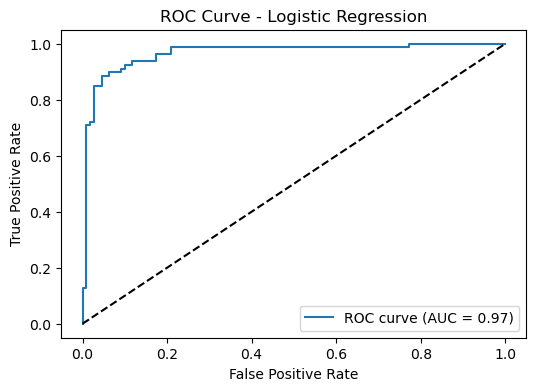

In [5]:
#ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc_score(y_test, y_proba):.2f})")
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc="lower right")
plt.show()

Now let's look at the feature importance with Random Forest:

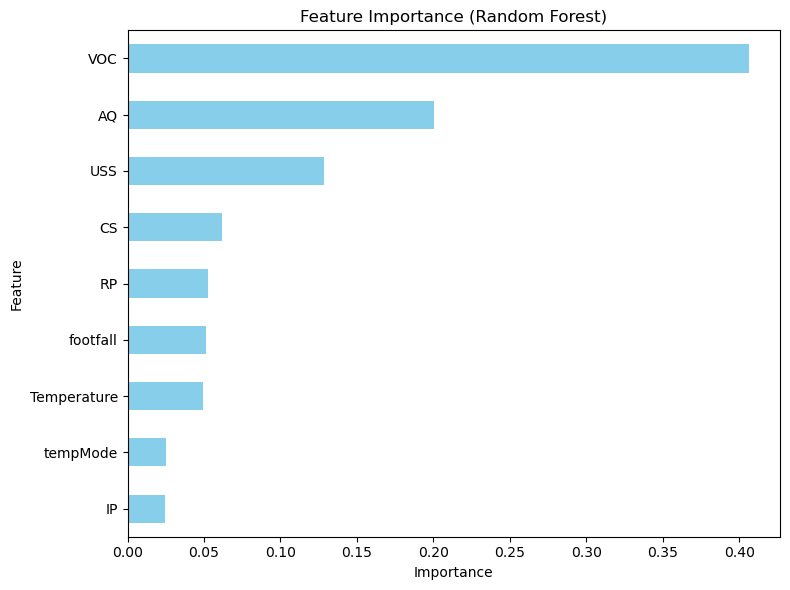

In [6]:
#RF
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)

#get feature importances
importances = pd.Series(rf.feature_importances_, index=X_train.columns)
importances.sort_values(ascending=True).plot(kind='barh', figsize=(8, 6), color='skyblue')
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [7]:
#cross-validation 
logreg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
cv_scores = cross_val_score(logreg, X_train, y_train, cv=5, scoring='roc_auc')

print("Cross-Validation AUC Scores:", cv_scores)
print("Mean AUC:", np.mean(cv_scores))

Cross-Validation AUC Scores: [0.96536797 0.97943723 0.95364358 0.97420635 0.96407625]
Mean AUC: 0.9673462737978868


Now, we analyse feature coefficients to interpret the impact of each variable on the target probability:

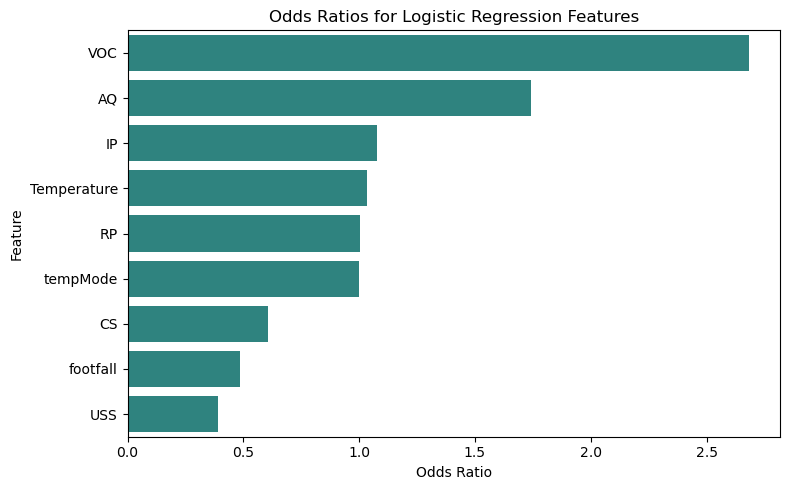

In [8]:
#odds ratios from logistic regression
odds_ratios = np.exp(model.coef_[0])
features = X_train.columns
odds_df = pd.DataFrame({'Feature': features, 'Odds Ratio': odds_ratios})
odds_df = odds_df.sort_values(by='Odds Ratio', ascending=False)

#we add a dummy hue column for visual consistency
odds_df['Hue'] = 'All'

# visualisation 
plt.figure(figsize=(8,5))
sns.barplot(x='Odds Ratio', y='Feature', data=odds_df, hue='Hue', palette='viridis', dodge=False)
plt.title('Odds Ratios for Logistic Regression Features')
plt.legend([],[], frameon=False)
plt.tight_layout()
plt.show()



Finally, we use SHAP values to understand the contribution of each feature to individual predictions:

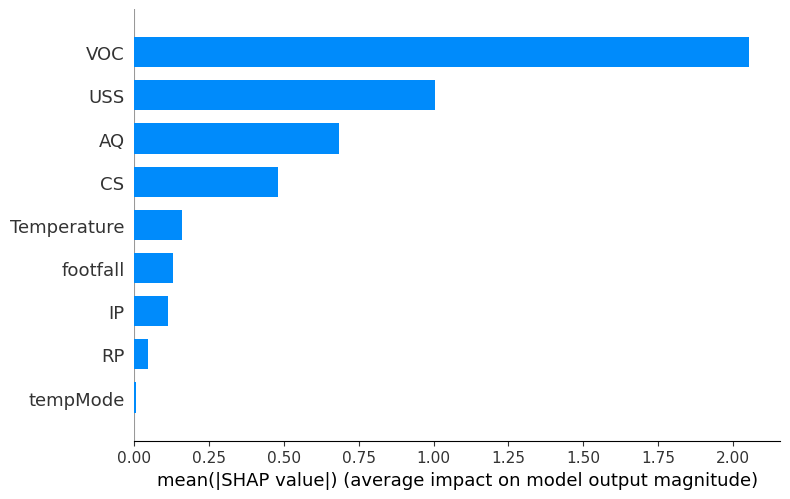

In [10]:
#create a SHAP explainer
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

#visualisation
shap.summary_plot(shap_values, X_test, plot_type='bar')

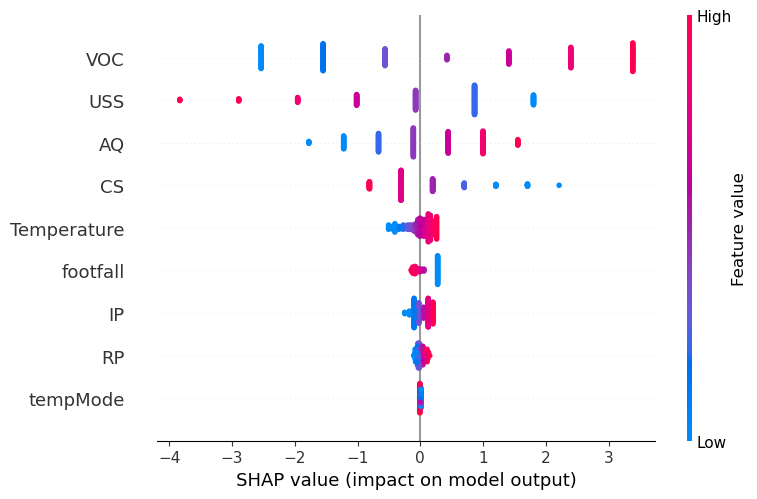

In [11]:
shap.summary_plot(shap_values, X_test)


The SHAP beeswarm plot below provides a global view of how each feature contributes to the model's predictions. 

- **VOC**, **USS**, **AQ**, and **CS** are the most influential variables in predicting failure.
- A **high VOC level** (in red) generally pushes the model output towards predicting a failure.
- Similarly, high values of **USS** and **AQ** also tend to increase the risk prediction.
- In contrast, features like `tempMode`, `RP`, and `IP` have limited influence on the model’s decisions.


Now let's dig a bit with the most influential variable : VOC

In [16]:
#we first get SHAP values as a numpy array
shap_array = shap_values.values

#then we find the index of VOC in the features
voc_idx = list(shap_values.feature_names).index("VOC")

#and get absolute SHAP values for VOC
voc_shap = np.abs(shap_array[:, voc_idx])
max_voc_idx = voc_shap.argmax()

print(f"Index of sample with highest VOC SHAP impact: {max_voc_idx}")

Index of sample with highest VOC SHAP impact: 0


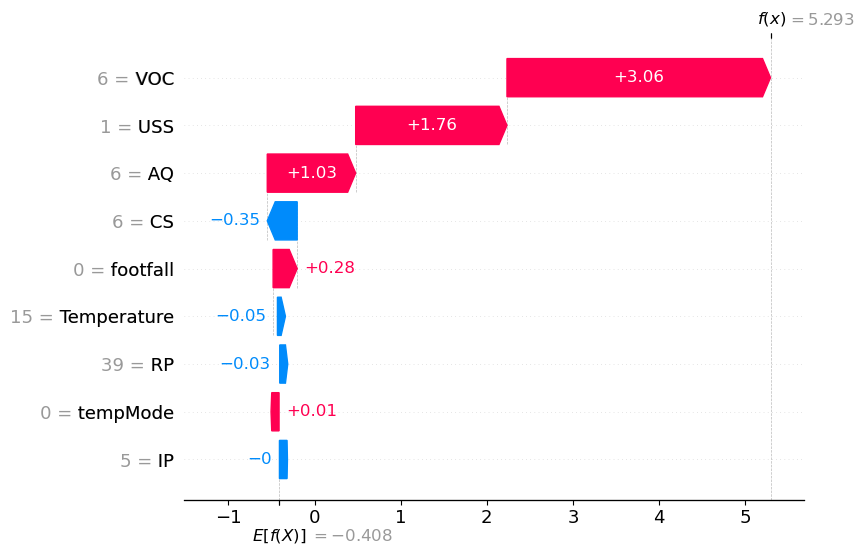

In [17]:
#plot for that sample
shap.plots.waterfall(shap_values[max_voc_idx])


This waterfall plot explains a single prediction where **VOC** had the highest SHAP impact.
- The model starts at the **base value** (*E[f(x)]*, average log-odds) and adds each feature’s contribution to reach the **final prediction** (*f(x)*).
- **Red bars** increase the predicted risk (toward failure), **blue bars** decrease it.
- Here, **high VOC (6)** is the dominant driver (**+3.06**), with **USS (1)** and **AQ (6)** also pushing the prediction upward.
- Minor negative contributions from **CS**, **Temperature**, and **RP** slightly reduce the risk.
- Final log-odds is **5.293**, corresponding to a **very high probability** of failure.
